In [250]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [251]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [252]:
len(words)

32033

In [253]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [254]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []

for w in words:

  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)

    # print(''.join(itos[i] for i in context), "---->", itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [255]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [256]:
C = torch.randn((27,2))

In [257]:
C[5]

tensor([ 0.2676, -0.1741])

In [258]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 0.2676, -0.1741])

In [259]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [260]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [261]:
h = emb.view(-1,6) @ W1 + b1

In [262]:
h

tensor([[-2.9634,  0.0241,  2.3137,  ...,  1.2170,  2.7112,  1.2226],
        [-2.3474,  1.0097,  2.6689,  ...,  0.3499,  2.2270,  0.5300],
        [-2.5529,  0.3199,  1.4715,  ...,  1.6983,  1.6602, -0.5450],
        ...,
        [-5.7595,  0.3771,  3.4611,  ..., -7.6472,  3.4826,  2.2783],
        [-3.0208,  4.7539,  3.9771,  ..., -3.4338, -2.9930,  5.3099],
        [-3.9817, -4.3422,  2.8837,  ...,  2.0264,  4.1622, -0.6732]])

torch view is very efficient

In [263]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [264]:
logits = h @ W2 + b2

In [265]:
logits.shape

torch.Size([228146, 27])

In [266]:
counts = logits.exp()

In [267]:
prob = counts / counts.sum(1, keepdims = True)

In [268]:
prob.shape

torch.Size([228146, 27])

In [269]:
prob[0].sum()

tensor(1.0000)

In [270]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [271]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

Bringing it all together

In [272]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [273]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6,100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100,27),  generator=g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [274]:
sum(p.nelement() for p in parameters)

3481

In [275]:
for p in parameters:
  p.requires_grad = True

In [276]:
# forward pass
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
## Old way
# counts = logits.exp()
# prob = counts/ counts.sum(1, keepdims = True)
# loss = -prob[torch.arange(32),Y].log().mean()

## Same as above but better
loss = F.cross_entropy(logits, Y) # Also more efficient in pytorch

loss

tensor(19.5052, grad_fn=<NllLossBackward0>)

In [277]:
# backward pass
for p in parameters:
  p.grad = None
loss.backward()

#update
for p in parameters:
  p.data += -0.1 * p.grad

In [278]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs[100:110]

tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021])

In [279]:
lri = []
lossi = []
for i in range(10000):

  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32, ))
  # forward pass
  emb = C[X[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix]) # Also more efficient in pytorch

  # print(loss)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #update
  lr = 0.1
  for p in parameters:
    p.data += -0.001 * p.grad

  # #track stats
  # lri.append(lre[i])
  # lossi.append(loss.item())

print(loss.item())

3.4745755195617676


In [281]:
logits.max(1)

torch.return_types.max(
values=tensor([5.1789, 5.9383, 5.5739, 4.4075, 2.9514, 2.7040, 2.4739, 2.9203, 5.1731,
        5.3111, 5.1731, 2.7242, 5.1731, 5.1731, 4.5964, 6.7896, 3.7394, 4.1997,
        3.8665, 5.3340, 3.7024, 5.2741, 6.9666, 2.4739, 5.1731, 3.8514, 4.2628,
        4.0986, 5.1731, 4.3112, 5.2176, 5.3772], grad_fn=<MaxBackward0>),
indices=tensor([13,  1,  0,  1,  0, 12,  5,  0,  1,  1,  1,  0,  1,  1,  1, 10, 18,  0,
        25,  1,  9,  0, 18,  5,  1,  5,  5,  1,  1,  9,  5,  1]))

In [282]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [283]:
# forward pass
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y) # Also more efficient in pytorch

print(loss)

tensor(3.5701, grad_fn=<NllLossBackward0>)


Cleaner code


In [284]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [345]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator = g)
W1 = torch.randn((30,200), generator = g)
b1 = torch.randn(200, generator = g)
W2 = torch.randn((200,27),  generator=g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [346]:
for p in parameters:
  p.requires_grad = True

In [371]:
lri = []
lossi = []
stepi = []

for i in range(50000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32, ))
  # forward pass
  emb = C[X[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix]) # Also more efficient in pytorch

  # print(loss)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #update
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  #track stats
  # lri.append(lre[i])
  lossi.append(loss.log10().item())
  stepi.append(i)


print(loss.item())

2.918287515640259


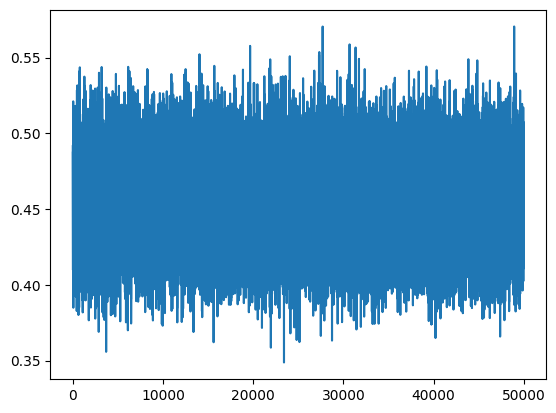

In [372]:
plt.plot(stepi,lossi)

In [373]:
# train loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr) # Also more efficient in pytorch

print(loss)

tensor(2.8693, grad_fn=<NllLossBackward0>)


In [375]:
# validate
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev) # Also more efficient in pytorch

print(loss)

tensor(2.8660, grad_fn=<NllLossBackward0>)


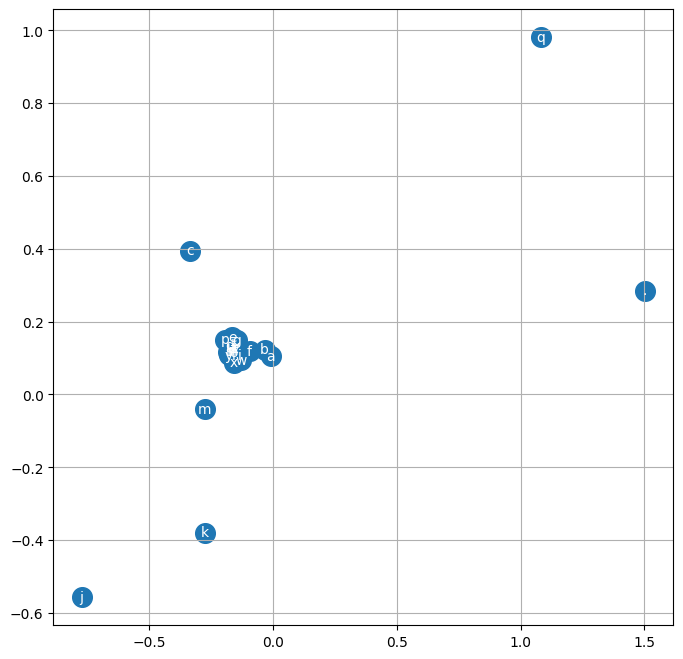

In [376]:
# visualize the embeddings
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [321]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 2])

In [377]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

eriaaimyayhreelmnd.
ryal.
.
ethrsjendrlrg.
.
deeed.
eliihemyorealedeiseananar.
elyzimhlkea.
n.
szdbvrglhiries.
.
n.
jr.
eel.
lxnteuorou.
z.
ned.
r.
y.
due.
